### 1D Autoregressive Token prediction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random

#### Data Preparation

##### Geometric Brownian Motion Simulator

$dS_t = \mu S_tdt + \sigma S_tdW_t \\$

$S_0$: Initial Stock price $\\$
$\mu$: Drift coefficient $\\$
$\sigma$: Volatility coefficient $\\$
$W_t$: Wiener Process (Brownian motion)

In [26]:
def gbm_simulator(key, S0, mu, sigma, T, dt):
    # Number of time steps
    N = int(T / dt)
    t = jnp.linspace(0, T, N)
    W = random.normal(key, (N,)) * jnp.sqrt(dt)
    
    # Wiener process
    W = jnp.cumsum(W)
    S = S0 * jnp.exp((mu - 0.5 * sigma**2) * t + sigma * W)
    return S

# Parameters for the GBM
S0 = 100.0                  # Initial stock price
mu = 0.1                    # Drift coefficient
sigma = 0.2                 # Volatility coefficient
T = 5.0                     # Total time (year)
dt = 0.005                  # Time step

# Generate random key
key = random.PRNGKey(0)

# Simulate GBM
GBM_data = gbm_simulator(key, S0, mu, sigma, T, dt)

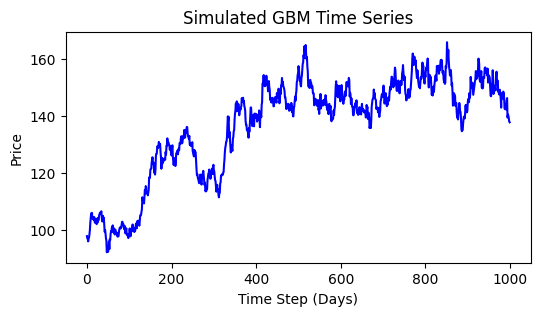

Mean Price: 136.36
Standard Deviation of Price: 17.87


In [27]:
# Plot the time series
plt.figure(figsize=(6, 3))
plt.plot(GBM_data, color ='blue')
plt.title('Simulated GBM Time Series')
plt.xlabel('Time Step (Days)')
plt.ylabel('Price')
plt.show()

# Calculate and print basic statistics
mean_price = jnp.mean(GBM_data)
std_dev_price = jnp.std(GBM_data)
print(f"Mean Price: {mean_price:.2f}")
print(f"Standard Deviation of Price: {std_dev_price:.2f}")

Discretizng data

In [34]:
data = np.array(GBM_data)
bin_start = 30
bin_stop = 180
num_bins = 30
bin_edges = np.linspace(bin_start, bin_stop, num_bins + 1)
# Tokenize the data
tokenized_data = np.digitize(GBM_data, bins=bin_edges, right=False) - 1
# Clip any prices below 30 to the first bin and above 170 to the last bin (Token 0 to 29)
tokenized_data = np.clip(tokenized_data, 0, num_bins - 1)
# Train / Test Split
train_data_temp, temp_data = train_test_split(tokenized_data, train_size=0.7, shuffle=False)
val_data_temp, test_data = train_test_split(temp_data, test_size=0.5, shuffle=False)

def prep_data(seq_len, start_indexes, data):
    final_list = []
    for i in start_indexes:
        final_list.append(data[i:i+seq_len])
    return final_list

In [55]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden=None):
        # A sequence of 50 tokens is passed to the embedding layer and we get the embeddings for each token (dimension: 32)
        embedded = self.embedding(x)                            # Shape: [batch_size, sequence_length, embedding_dim] [1, 50, 32]
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(embedded, hidden)      # Input: 50 tokens, Output: 50 hidden states with dimension 128
        # Apply fully connected layer to each time step
        logits = self.fc(lstm_out)                              # Shape: [batch_size, sequence_length, output_dim]
        
        return logits, hidden                                   # Return predictions for each time step

In [56]:
seq_len = 50
train_n_seq = 10

val_data = []
for i in range(len(val_data_temp) // seq_len):
    start_idx = i * seq_len
    end_idx = start_idx + seq_len
    val_data.append(val_data_temp[start_idx:end_idx])

Loss function and training (no early stopping and not )

In [58]:
model = LSTMModel(vocab_size=num_bins, embedding_dim=32, hidden_dim=64, output_dim=num_bins)

# Loss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training

num_epochs = 300
train_losses = []
validation_losses = []

for epoch in range(num_epochs):
    
    start_train_index = np.random.choice(range(len(train_data_temp)-seq_len), size=train_n_seq, replace=True)
    train_data = prep_data(seq_len=seq_len, start_indexes=start_train_index, data=train_data_temp)
    
    ## TRAINING
    model.train()
    train_loss = 0
    for sequence in train_data:
        
        optimizer.zero_grad()

        sequence_input = torch.tensor(sequence[:-1]).unsqueeze(0)   # Exclude last token
        targets = torch.tensor(sequence[1:]).unsqueeze(0)           # Exclude first token

        # Shape: [1, sequence_length-1, unique_tokens]
        logits, _ = model(sequence_input)                              # [Token 1, Token 2, ..., Token 49]
        # Reshape logits to combine batch and sequence dimensions
        logits = logits.view(-1, logits.size(-1))                   # Shape: [1*49, 30] -> [49, 30]
        targets = targets.view(-1)                                  # Flatten targets to shape [49]
        # Average loss across all 49 tokens
        loss = criterion(logits, targets)
        train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    avg_train_loss = train_loss/len(train_data)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch} - Avg Loss per sequence: {avg_train_loss:.4f}")

    ## VALIDATION
    model.eval()
    validation_loss = 0

    # No weight updates
    with torch.no_grad():
        for sequence in val_data:
            sequence_input = torch.tensor(sequence[:-1]).unsqueeze(0)   # Exclude last token
            targets = torch.tensor(sequence[1:]).unsqueeze(0)           # Exclude first token

            logits, _ = model(sequence_input)  # Forward pass
            logits = logits.view(-1, logits.size(-1))  # Shape: [49, 30]
            targets = targets.view(-1)  # Shape: [49]                        
            loss = criterion(logits, targets)
            validation_loss += loss.item()
        
    avg_val_loss = validation_loss / len(val_data)
    validation_losses.append(avg_val_loss)
    print(f"Epoch {epoch}, Validation Loss: {avg_val_loss:.4f}")

# Save model weights after training/validation
torch.save(model.state_dict(), 'model_weights.pth')

Epoch 0 - Avg Loss per sequence: 3.2649
Epoch 0, Validation Loss: 3.1650
Epoch 1 - Avg Loss per sequence: 3.1853
Epoch 1, Validation Loss: 3.0454
Epoch 2 - Avg Loss per sequence: 2.8431
Epoch 2, Validation Loss: 2.9271
Epoch 3 - Avg Loss per sequence: 2.5862
Epoch 3, Validation Loss: 2.7480
Epoch 4 - Avg Loss per sequence: 2.2558
Epoch 4, Validation Loss: 2.5099
Epoch 5 - Avg Loss per sequence: 2.0330
Epoch 5, Validation Loss: 2.3271
Epoch 6 - Avg Loss per sequence: 1.7425
Epoch 6, Validation Loss: 2.1453
Epoch 7 - Avg Loss per sequence: 1.5382
Epoch 7, Validation Loss: 1.9987
Epoch 8 - Avg Loss per sequence: 1.5900
Epoch 8, Validation Loss: 1.8593
Epoch 9 - Avg Loss per sequence: 1.3933
Epoch 9, Validation Loss: 1.8209
Epoch 10 - Avg Loss per sequence: 1.5375
Epoch 10, Validation Loss: 1.7508
Epoch 11 - Avg Loss per sequence: 1.1977
Epoch 11, Validation Loss: 1.7040
Epoch 12 - Avg Loss per sequence: 1.2459
Epoch 12, Validation Loss: 1.6662
Epoch 13 - Avg Loss per sequence: 1.2461
Epoc

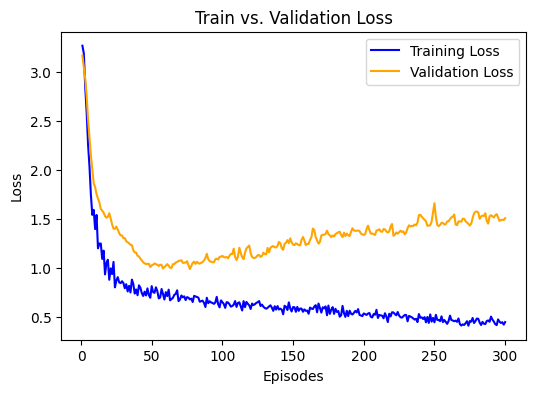

In [59]:
plt.figure(figsize=(6,4))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, len(validation_losses)+1), validation_losses, label = 'Validation Loss', color='orange')
plt.title('Train vs. Validation Loss')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.legend()
plt.show()

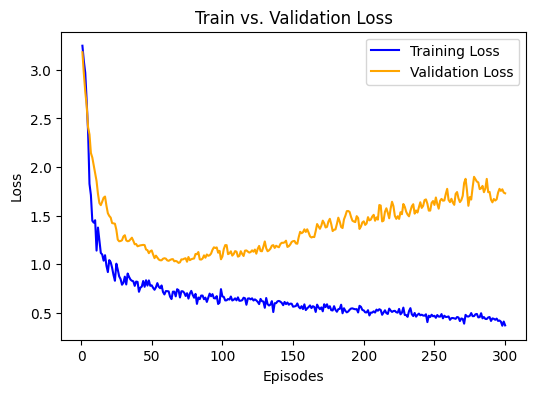

In [43]:
plt.figure(figsize=(6,4))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, len(validation_losses)+1), validation_losses, label = 'Validation Loss', color='orange')
plt.title('Train vs. Validation Loss')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.legend()
plt.show()

Testing

In [52]:
test_data[0]

25

In [ ]:
# Load model weights before testing
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()  # Set model to evaluation mode


In [381]:
def prep_test_data()

3

In [ ]:



init_real_token = test_data[0]
sim_trajectory = [init_real_token]
model.eval()

# Initialize hidden and cell states to zero
## PLEASE ADJUST WHEN HAVING MULTIPLE LSTM LAYERS
h_n = torch.zeros(1, 1, 64)
c_n = torch.zeros(1, 1, 64)
##

test_losses = []

## TESTING 
with torch.no_grad():
    for i in range(1, seq_len):
        # Last value in the trajectory
        sequence_input = torch.tensor([sim_trajectory[-1]]).unsqueeze(0)
        # Get the model's prediction and pass the hidden and cell states
        logits, (h_n, c_n) = model(sequence_input, (h_n, c_n))
        # Apply softmax to get probabilities
        probs = torch.softmax(logits, dim=-1)
        probs = probs.squeeze()
        predicted_token = torch.multinomial(probs, num_samples=1).item()
        sim_trajectory.append(predicted_token)

        true_token = torch.tensor([test_data[i]]).unsqueeze(0)
        logits = logits.view(-1, logits.size(-1))                   
        true_token = true_token.view(-1)                            
        loss = criterion(logits, true_token)
        test_losses.append(loss.item())

print(sim_trajectory)
print(test_losses)





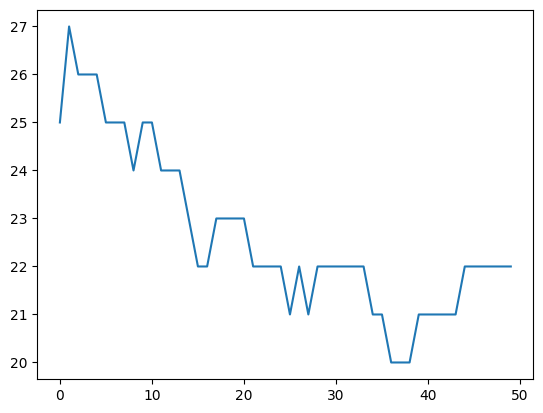

In [384]:
plt.plot(test_data[:50])

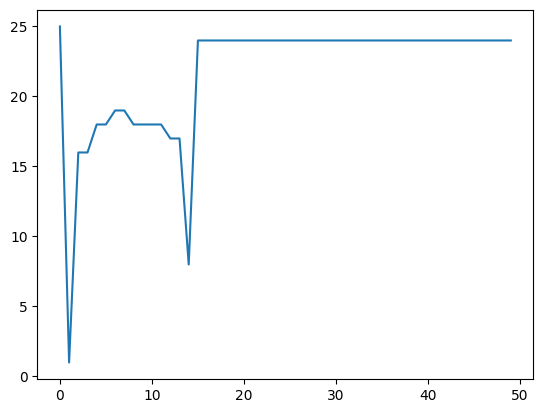

In [383]:
plt.plot(sim_trajectory)

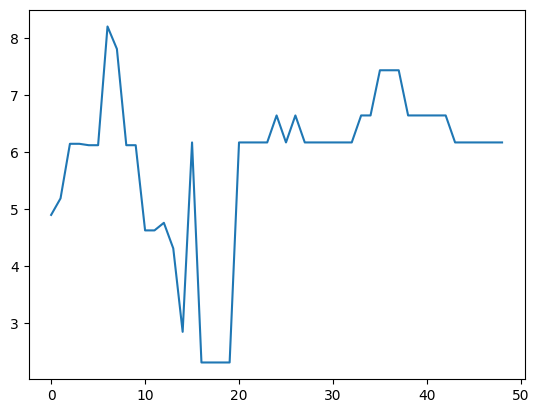

In [378]:
plt.plot(test_losses)

In [92]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append(seq)
        targets.append(target)
    return torch.tensor(sequences), torch.tensor(targets)

seq_length = 50  # Example sequence length

# [Input][Output], [1-50][51], [2-51][52], ... ,[750-799][800]
train_sequences, train_targets = create_sequences(train_data, seq_length)
val_sequences, val_targets = create_sequences(val_data, seq_length)
test_sequences, test_targets = create_sequences(test_data, seq_length)


In [93]:
# Create TensorDataset for each set
train_dataset = TensorDataset(train_sequences, train_targets)
val_dataset = TensorDataset(val_sequences, val_targets)
test_dataset = TensorDataset(test_sequences, test_targets)

# Create DataLoader for each set
batch_size = 32  # Example batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# Check the loader
for batch_idx, (data, target) in enumerate(val_loader):
    print(batch_idx)
    print(data[3])
    print(target[3])


In [224]:
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim)
torch.argmax(model.forward(val_1), dim = 1)

tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10,  7,  7,  7, 10, 10])

In [115]:
# Example model parameters
embedding_dim = 32              # Size of embedding vector
hidden_dim = 128                # Number of LSTM units
vocab_size = num_bins           # Number of unique Tokens
output_dim = vocab_size         # Ouput size is the number of unique Tokens again

In [158]:
data_iter = iter(val_loader)

# Get the first batch
first_batch = next(data_iter)
val_1, target_1 = first_batch
print(val_1[0])
print(target_1[0])

tensor([ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11,
        12, 11, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11])
tensor(11)
